In [30]:
from cgitb import enable
import os
import re
import plotly
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from Bio import SeqIO
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential

from scipy.stats import spearmanr

from models import deepSequenceSimple
from utils import (
    get_data,
    plot_latent,
    plot_losses,
    train,
    validate,
    vae_loss,
    LossAccumulator,
    aa1_to_index,
)


In [ ]:

# FASTA parser requires Biopython

BATCH_SIZE = 16
MAX_NUM_EPOCHS = 200
EARLY_STOPPING = 20
DEBUG_MODE = False
PRINT_FREQ = 1500


train_dataset, valid_dataset, weights, phyla_map = get_data(
    "data/BLAT_ECOLX_1_b0.5_labeled.fasta", calc_weights=False
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=True
)

model = deepSequenceSimple(
    enable_bn=False, activation_function="ReLU", gate_function="Softmax"
)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=[0.5, 0.999])  #
loss_function = vae_loss
loss_acc = LossAccumulator(keys=["mse", "kl"])


losses = []
best_val_loss = np.inf
noImprovementSince = 0
for epoch in range(MAX_NUM_EPOCHS):
    train_losses = train(
        train_loader, model, optimizer, loss_function, loss_acc, epoch, DEBUG_MODE
    )
    valid_losses = validate(
        valid_loader, model, optimizer, loss_function, loss_acc, epoch
    )

    epoch_losses = {"train_" + k: v for k, v in train_losses.items()}
    epoch_losses.update({"valid_" + k: v for k, v in valid_losses.items()})
    epoch_losses.update({"epoch": epoch})
    losses += [epoch_losses]

    if epoch % 20 == 0:
        plot_latent(model, train_loader, valid_loader, False, epoch, phyla_map)
        print("plotted")

    plot_losses(losses)

    if valid_losses["total"] < best_val_loss:
        noImprovementSince = 0
        best_val_loss = valid_losses["total"]
    else:
        print(f"No Improvement on validation set in {noImprovementSince} epochs")
        noImprovementSince += 1

    if noImprovementSince >= EARLY_STOPPING:
        print(f"No Improvement on validation set in {EARLY_STOPPING} epochs, quitting")
        plot_latent(model, train_loader, valid_loader, False, epoch)
        break

    if DEBUG_MODE:
        break


def read_experimental_data(filename, measurement_col_name="2500", sequence_offset=0):
    """Read experimental data from csv file, and check that amino acid match those
    in the first sequence of the alignment.

    measurement_col_name specifies which column in the csv file contains the experimental
    observation. In our case, this is the one called 2500.

    sequence_offset is used in case there is an overall offset between the
    indices in the two files.
    """

    measurement_df = pd.read_csv(
        filename, delimiter=",", usecols=["mutant", measurement_col_name]
    )

    zero_index = None

    experimental_data = {}
    for idx, entry in measurement_df.iterrows():
        mutant_from, position, mutant_to = (
            entry["mutant"][:1],
            int(entry["mutant"][1:-1]),
            entry["mutant"][-1:],
        )

        # Use index of first entry as offset (keep track of this in case
        # there are index gaps in experimental data)
        if zero_index is None:
            zero_index = position

        # Corresponding position in our alignment
        seq_position = position - zero_index + sequence_offset

        # Make sure that two two inputs agree on the indices: the
        # amino acids in the first entry of the alignment should be
        # identical to those in the experimental file.
        # assert mutant_from == aa1[wt_sequence[seq_position]]

        if seq_position not in experimental_data:
            experimental_data[seq_position] = {}

        # Check that there is only a single experimental value for mutant
        assert mutant_to not in experimental_data[seq_position]

        experimental_data[seq_position]["pos"] = seq_position
        experimental_data[seq_position]["WT"] = mutant_from
        experimental_data[seq_position][mutant_to] = entry[measurement_col_name]

    experimental_data = (
        pd.DataFrame(experimental_data).transpose().set_index(["pos", "WT"])
    )
    return experimental_data


experimental_data = read_experimental_data("data/BLAT_ECOLX_Ranganathan2015.csv")
experimental_data




In [31]:
def approximate_log_ratios(
    experimental_data, model, device, num_samples=10, model_type="vae", N_pred_iterations=100
):

    experimental_values = np.empty((263, 20))
    approximate_vae_values = np.empty((263, 20))

    # compute x_WT
    x_WT = torch.empty(263)
    for (position, mutant_from), _ in experimental_data.iterrows():
        x_WT[position] = aa1_to_index[mutant_from]

    x_WT_ = x_WT.clone()

    # get output for x_WT
    x_WT = x_WT[None, :]
    if model_type == "iwae":
        dim_0, dim_1 = x_WT.size()
        x_WT = x_WT.expand(num_samples, dim_0, dim_1)
    x_WT = x_WT.to(device)
    if model_type == "vae":
        x_WT = F.one_hot(x_WT.long())

        # Add 0s for 3 classes that aren't included in experimental data
        x_WT = F.pad(x_WT, pad=(0, 3)).float()
        WT_elbos = []
        for i in range(N_pred_iterations):
            outputs = model([x_WT])
            losses = loss_function([x_WT], outputs)
            WT_elbos += [sum([x[1] for x in losses]).detach().cpu().numpy()]
        elbo_WT = np.mean(WT_elbos)
        # elbo_WT, _, _ = model.calculate_loss(x_WT, device=device)
    else:
        elbo_WT = model.calculate_loss(x_WT, beta=1.0, device=device)

    # approximate log ratios
    for (position, mutant_from), row in tqdm(experimental_data.iterrows(), total=len(experimental_data)):
        i = 0
        for mutant_to, exp_value in row.iteritems():
            if not np.isnan(exp_value):
                # compute x_MT
                x_MT = x_WT_.clone()

                x_MT[position] = aa1_to_index[mutant_to]
                # get output for x_MT
                x_MT = x_MT[None, :]
                x_MT = F.one_hot(x_MT.long())

                # Add 0s for 3 classes that aren't included in experimental data
                x_MT = F.pad(x_MT, pad=(0, 3)).float()
                if model_type == "iwae":
                    dim_0, dim_1 = x_MT.size()
                    x_MT = x_MT.expand(num_samples, dim_0, dim_1)
                x_MT = x_MT.to(device)
                if model_type == "vae":
                    MT_elbos = []
                    for i in range(N_pred_iterations):
                        outputs = model([x_MT])
                        losses = loss_function([x_MT], outputs)
                        MT_elbos += [sum([x[1] for x in losses]).detach().cpu().numpy()]
                    elbo_MT = np.mean(MT_elbos)
                    # elbo_MT, _, _ = model.calculate_loss(x_MT, device=device)
                else:
                    wtf
                    elbo_MT = model.calculate_loss(x_MT, beta=1.0, device=device)
                # compute the approximate log-ratio
                approx_log_ratio = elbo_MT - elbo_WT
                
                # store values in numpy arrays
                approximate_vae_values[position, i] = approx_log_ratio.item()
                experimental_values[position, i] = exp_value

            else:
                approximate_vae_values[position, i] = 0.0
                experimental_values[position, i] = np.nan
            i += 1

    # compute the Spearman R statistics
    correlation, pvalue = spearmanr(
        experimental_values.flatten(),
        approximate_vae_values.flatten(),
        nan_policy="omit",
    )
    return experimental_values, approximate_vae_values, correlation, pvalue
e, a, c, p = approximate_log_ratios(experimental_data, model, "cuda")

AttributeError: 'torch.dtype' object has no attribute 'type'

In [13]:
F.one_hot(torch.tensor([4,0,2,3]))

tensor([[0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0]])

In [14]:
experimental_values = np.empty((263, 20))
approximate_vae_values = np.empty((263, 20))

# compute x_WT
x_WT = torch.empty(263)
for (position, mutant_from), _ in experimental_data.iterrows():
    x_WT[position] = aa1_to_index[mutant_from]

x_WT_ = x_WT.clone()

# get output for x_WT
x_WT = x_WT[None, :]
if model_type == "iwae":
    dim_0, dim_1 = x_WT.size()
    x_WT = x_WT.expand(num_samples, dim_0, dim_1)
x_WT = x_WT.to(device)
if model_type == "vae":
    x_WT = F.one_hot(x_WT.long())

    # Add 0s for 3 classes that aren't included in experimental data
    x_WT = F.pad(x_WT, pad=(0, 3)).float()
    outputs = model([x_WT])
    losses = loss_function([x_WT], outputs)
    elbo_WT = sum([x[1] for x in losses])
    # elbo_WT, _, _ = model.calculate_loss(x_WT, device=device)
else:
    elbo_WT = model.calculate_loss(x_WT, beta=1.0, device=device)

MultiIndex([(  0, 'H'),
            (  1, 'P'),
            (  2, 'E'),
            (  3, 'T'),
            (  4, 'L'),
            (  5, 'V'),
            (  6, 'K'),
            (  7, 'V'),
            (  8, 'K'),
            (  9, 'D'),
            ...
            (253, 'E'),
            (254, 'I'),
            (255, 'G'),
            (256, 'A'),
            (257, 'S'),
            (258, 'L'),
            (259, 'I'),
            (260, 'K'),
            (261, 'H'),
            (262, 'W')],
           names=['pos', 'WT'], length=263)

<AxesSubplot:>

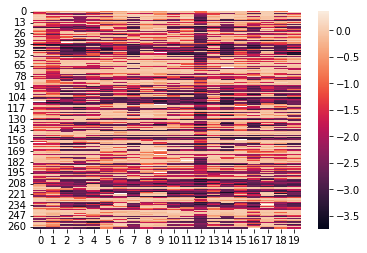

In [28]:
sns.heatmap(e)

<AxesSubplot:ylabel='pos-WT'>

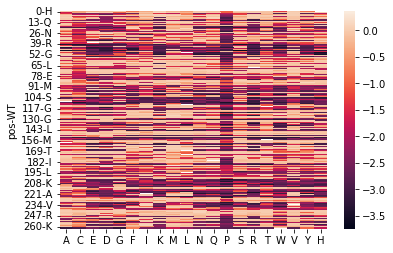

In [22]:
sns.heatmap(experimental_data.applymap(lambda x: float(x)))

<AxesSubplot:>

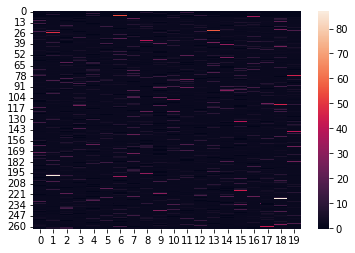

In [29]:
sns.heatmap(a)

In [26]:
np.log(5/10)

-0.6931471805599453